# Leer las ondas
1) Imports

In [1]:
import psycopg2
from psycopg2.extensions import register_adapter, AsIs
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from oct2py import octave
#para el tiempo
from datetime import datetime
import pandas as pd
octave.addpath('/home/scidb/HeartRatePatterns/Matlab/')
octave.eval('pkg load signal')

Leer la base de datos para decidir que Ondas vamos a traer

In [2]:
def obtainWaveFormFields(dbname="mimic") :
    labels='II'
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_stament = ("SELECT lef.subject_id,lef.recorddate,lef.signame,lef.fs "
                      " FROM waveformfields lef "
                      " LEFT JOIN (SELECT MAX(recorddate) AS recorddate,subject_id "
                      " FROM waveformFields GROUP BY subject_id) rig "
                      " ON lef.subject_id = rig.subject_id "
                      " AND lef.recorddate = rig.recorddate "
                      " WHERE rig.subject_id IS NOT NULL "
                      " AND signame @> ARRAY['"+labels+"']::varchar[] "
                      " AND lef.database= 'mimic2'"
                      " AND lef.subject_id not in (52,124,135,151,177,214,263,279,283)")
    cur.execute(select_stament)
    waves = []
    for row in cur :
        patient = "s"+str(row[0]).zfill(5)
        onda = patient+'-'+row[1]
        carpeta = patient
        waves.append({"subject_id":row[0],"recorddate":row[1],"fs":row[3],"onda":onda,"carpeta":carpeta,
                      "signalII":row[2].index("II")})
    conn.close()
    return waves

In [3]:
def notExistQRST(record,table="rstq"):
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    select_stament = 'select id from '+table+' where record= %s'
    cur.execute(select_stament,(record,))
    exist = cur.fetchone() is None
    conn.close()
    return exist

In [4]:
waves = obtainWaveFormFields()
wave = waves[0]
carpeta = wave["carpeta"]
onda = wave["onda"]
signalII = wave["signalII"]
fs = wave["fs"]
subject_id = wave["subject_id"]
recorddate = wave["recorddate"]
record="mimic2wdb/matched/"+carpeta+"/"+onda
print(record)
if notExistQRST(record) :
    signal = wfdb.rdsamp(onda,pbdir='mimic2wdb/matched/'+carpeta,channels =[signalII]).p_signals


mimic2wdb/matched/s00308/s00308-2915-08-28-04-22


In [5]:
def updateSignal(subject_id,recorddate,signallen,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    update_stament = "UPDATE waveformfields SET signallength=(%s) WHERE subject_id = (%s) AND recorddate = (%s)"
    cur.execute(update_stament,(signallen,subject_id,recorddate))
    conn.commit()

In [6]:
def subSignal(signal) :
    signalNan = signal[~np.isnan(signal)]
    signalSize = 1800000
    print("La señal tiene ",len(signalNan)," registros extraemos las ultimas 4 horas")
    if len(signalNan)<signalSize :
        subsignal = signalNan
    else :
        subsignal = signalNan[-1800000:]
    return subsignal.tolist()

In [7]:
updateSignal(subject_id,recorddate,len(signal))
subsignal = subSignal(signal)
len(subsignal)
#subsignal[1001500:1002000]

La señal tiene  26975194  registros extraemos las ultimas 4 horas


1800000

Extraemos las ultimas 4 horas osea 1'800.000 registros

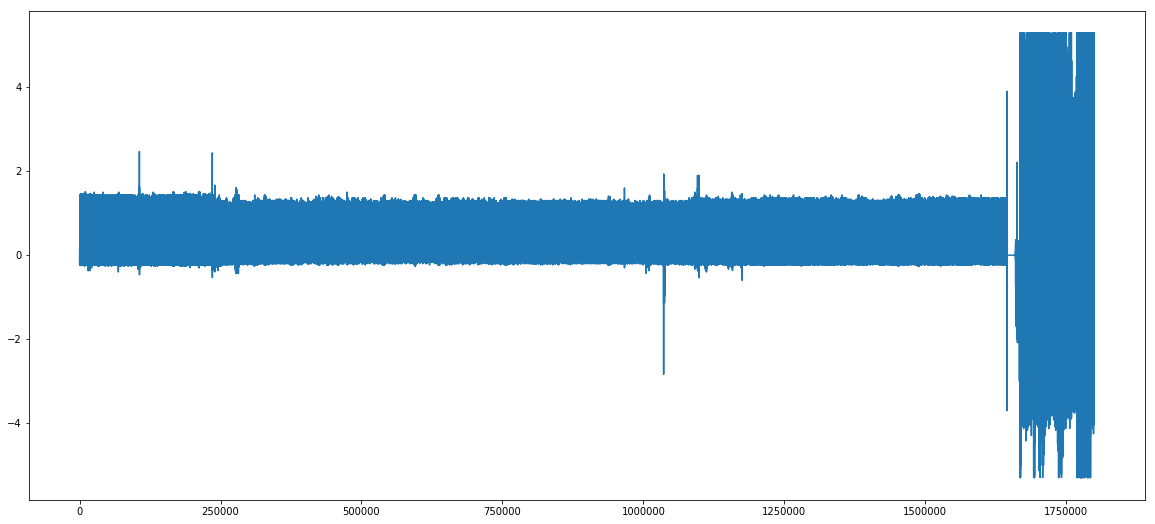

In [8]:
fig_size = [20,9]
plt.rcParams["figure.figsize"] = fig_size
plt.plot(subsignal)
#plt.plot(signal[:,1])
plt.show()

In [9]:
def peakdetect(signal, fs,increment=0,previousResult=None):
    if previousResult is None:
        previousResult = {'Q_s':[],'Q_a':[],'R_s':[],'R_s':[],'S_s':[],'S_s':[],'T_s':[],'T_s':[]}
    (R_s,R_a,S_s,S_a,T_s,T_a,Q_s,Q_a,heart_rate,buffer_plot) = octave.peakdetect(signal,fs,False, nout=10)
    return {'Q_s'  :np.concatenate((previousResult['Q_s'],  Q_s[0]+increment)),
            'Q_a'  :np.concatenate((previousResult['Q_a'],  Q_a[0])),
            'R_s'  :np.concatenate((previousResult['R_s'],  R_s[0]+increment)),
            'R_a'  :np.concatenate((previousResult['R_a'],  R_a[0])),
            'S_s'  :np.concatenate((previousResult['S_s'],  S_s[0]+increment)),
            'S_a'  :np.concatenate((previousResult['S_a'],  S_a[0])),
            'T_s'  :np.concatenate((previousResult['T_s'],  T_s[0]+increment)),
            'T_a'  :np.concatenate((previousResult['T_a'],  T_a[0])),
           }

In [10]:
def audit(before=datetime.now()):
    now = datetime.now()
    print("hasta aqui van",(now-before))
    return now

def checkwave(signal,fs):
    now = audit()
    windowsize = 3000*fs
    signalsize = len(signal)
    previousResult = {'Q_s':[],'Q_a':[],'R_s':[],'R_a':[],'S_s':[],'S_a':[],'T_s':[],'T_a':[]}
    termino = True
    fin=0
    while termino:
        ini=fin
        fin=fin+ (windowsize)
        if(fin>signalsize):
            fin=signalsize
        now = audit(now)
        print("ini",ini,"fin",fin)
        previousResult = peakdetect(signal[ini:fin],fs,increment=ini,previousResult=previousResult)
        now = audit(now)
        termino = fin<signalsize
    return previousResult

In [11]:
previousResult = checkwave(subsignal,fs)

hasta aqui van 0:00:00.022458
hasta aqui van 0:00:00.002511
ini 0 fin 375000
hasta aqui van 1:35:19.136765
hasta aqui van 0:00:00.000232
ini 375000 fin 750000


Oct2PyError: Octave evaluation error:
error: buffer_plot(-3): subscripts must be either integers 1 to (2^31)-1 or logicals

In [ ]:
plt.scatter(previousResult['Q_s'], previousResult['Q_a'],c='yellow')
plt.scatter(previousResult['R_s'], previousResult['R_a'],c='blue')
plt.scatter(previousResult['S_s'], previousResult['S_a'],c='red')
plt.scatter(previousResult['T_s'], previousResult['T_a'],c='black')
plt.plot(subsignal,c='lightgreen')
plt.show()

In [ ]:
init = 6
end = 10
plt.plot(subsignal[int(previousResult['Q_s'][init]):int(previousResult['T_s'][end])],c='lightgreen')
plt.scatter(previousResult['Q_s'][init:end]-int(previousResult['Q_s'][init]), previousResult['Q_a'][init:end],c='yellow')
plt.scatter(previousResult['R_s'][init:end]-int(previousResult['Q_s'][init]), previousResult['R_a'][init:end],c='blue')
plt.scatter(previousResult['S_s'][init:end]-int(previousResult['Q_s'][init]), previousResult['S_a'][init:end],c='red')
plt.scatter(previousResult['T_s'][init:end]-int(previousResult['Q_s'][init]), previousResult['T_a'][init:end],c='black')
plt.show()

In [ ]:
print('Q',len(previousResult['Q_s']), len(previousResult['Q_a']))
print('R',len(previousResult['R_s']), len(previousResult['R_a']))
print('S',len(previousResult['S_s']), len(previousResult['S_a']))
print('T',len(previousResult['T_s']), len(previousResult['T_a']))

In [ ]:
def difference(first,second):
    if first is None or second is None :
        return None
    else :
        return first-second

In [ ]:
def readsignal(next1,next2,next3,wave,amp,i,signal) :
    currentw = int(signal[wave][i]) if len(signal[wave])>i else None
    if currentw is None or (next2 is not None and currentw>next2) or (next3 is not None and currentw>next3):
        return None,None,i
    if(next1 is None or currentw<=next1) :
        currentw,waveamp,i = currentw,signal[amp][i],i+1
    else :
        currentw,waveamp = None,None
    return currentw,waveamp,i
def sortHeartBeats(signal,originalSignal) :
    q,s,t,r,result = 0,0,0,0,None
    index = 0
    while q<len(signal['Q_s']) and r<len(signal['R_s']) and s<len(signal['S_s'])  and t<len(signal['T_s']) :
        sinext = signal['S_s'][s]   if s  <len(signal['S_s']) else None
        tinext = signal['T_s'][t]   if t  <len(signal['T_s']) else None
        qinext = signal['Q_s'][q]   if q  <len(signal['Q_s']) else None
        rinext = signal['R_s'][r+1] if r+1<len(signal['R_s']) else None
        siNext = signal['S_s'][r+1] if r+1<len(signal['S_s']) else None
        tiNext = signal['T_s'][r+1] if r+1<len(signal['T_s']) else None
        
        ri,ra,r = readsignal(sinext,tinext,qinext,'R_s','R_a',r,signal)
        si,sa,s = readsignal(tinext,qinext,rinext,'S_s','S_a',s,signal)
        ti,ta,t = readsignal(qinext,rinext,siNext,'T_s','T_a',t,signal)
        qi,qa,q = readsignal(rinext,siNext,tiNext,'Q_s','Q_a',q,signal)
        if qi is not None and ti is not None :
            wave = originalSignal[int(qi):int(ti)]
        else :
            wave = None
      #  print("q",q,"r",r,"s",s,"t",t,"wave",wave)
        dic = {'Q_s':qi,'Q_a':qa,
               'R_s':ri,'R_a':ra,
               'S_s':si,'S_a':sa,
               'T_s':ti,'T_a':ta,
               'qt':difference(qi,ti),'ts':difference(ti,si),'sr':difference(si,ri),
              'wave':[wave]}
        if result is None :
            result = pd.DataFrame(dic, index=[index])
        else :
            result = pd.concat([result,  pd.DataFrame(dic, index=[index])])
        index=index+1
    return result
sortBeats = sortHeartBeats(previousResult,subsignal)

In [ ]:
def checkQRST(qrst) :
    shape = qrst.shape[0]
    x = 0
    while x<shape :
        qiNotNone = qrst.iloc[x]["Q_s"] is not None
        riNotNone = qrst.iloc[x]["R_s"] is not None
        siNotNone = qrst.iloc[x]["S_s"] is not None
        tiNotNone = qrst.iloc[x]["T_s"] is not None
        if(riNotNone and siNotNone and qrst.iloc[x]["R_s"]>qrst.iloc[x]["S_s"]) :
            print("R>S en",x)
        if(siNotNone and tiNotNone and qrst.iloc[x]["S_s"]>qrst.iloc[x]["T_s"]) :
            print("S>T en",x)
        if(qiNotNone and tiNotNone and qrst.iloc[x]["T_s"]>qrst.iloc[x]["Q_s"]) :
            print("T>Q en",x," qt value",qrst.iloc[x]["qt"])
        x=x+1
checkQRST(sortBeats)

In [ ]:
print(sortBeats.iloc[2112:2114])

In [ ]:
def addapt_numpy_float64(numpy_float64):
  return AsIs(numpy_float64)
register_adapter(np.float64, addapt_numpy_float64)
def addapt_numpy_int64(numpy_int64):
  return AsIs(numpy_int64)
register_adapter(np.int64, addapt_numpy_int64)

In [ ]:
#sortBeats = sortBeats.assign(subject_id=int(subject_id)).assign(recorddate=recorddate)
sortBeats['record'] = record
def saveQRST(qrst) :
    conn = psycopg2.connect("dbname=mimic")
    cur = conn.cursor()
    table = "rstq"
    cur.execute("CREATE TABLE IF NOT EXISTS "+table+
            " (id serial NOT NULL, "+
                " record character varying(50), "+
                " r_s integer, "+
                " r_a double precision, "+
                " s_s integer, "+
                " s_a double precision, "+
                " t_s integer,  "+
                "  t_a double precision, "+
                "  q_s integer, "+
                "  q_a double precision, "+
                "  qt integer, "+
                "  ts integer, "+
                "  sr integer, "+
                "  centroid character varying(50), "+
                "  wave real[], "+
                "  CONSTRAINT rstq_pkey PRIMARY KEY (id));")
    insert_statement = 'insert into '+table+' (%s) values %s'
    for index, row in qrst.iterrows():
        columns = row.keys()
        values = [row[column] for column in columns]
 #       print(cur.mogrify(insert_statement, (AsIs(','.join(columns)), tuple(values))))
        cur.execute(insert_statement, (AsIs(','.join(columns)), tuple(values)))
    conn.commit()
    conn.close()
saveQRST(sortBeats)